In [1]:
import tensorflow as tf
from tensorflow import keras
import PIL
import os
from PIL import Image
from skimage.io import imread_collection
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
import pandas as pd
import re

In [3]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16

In [4]:
def sorted_nicely(l):
    """ Sorts the given iterable in the way that is expected.
 
    Required arguments:
    l -- The iterable to be sorted.
 
    """
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key = alphanum_key)

In [5]:
def absSobelThresh(img, orient, thresh, sobelKernel = 19):
    
    threshMin=thresh[0]
    threshMax=thresh[1]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobelOp = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobelKernel)
    else:
        sobelOp = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobelKernel)
    absSobel = np.absolute(sobelOp)
    scaledSobel = np.uint8(255*absSobel/np.max(absSobel))
    sxbinary = np.zeros_like(scaledSobel)
    sxbinary[(scaledSobel > threshMin) & (scaledSobel < threshMax)] = 1
    binaryOutput = sxbinary 
    
    return binaryOutput

def combinedThreshBinaryImg(img, threshX, threshY, threshColorS, threshColorU, threshColorR):

    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float)
    yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV).astype(np.float)
    L = hls[:,:,1]
    S = hls[:,:,2]
    R = rgb[:,:,0]
    U = yuv[:,:,1]
    sobelX = absSobelThresh(img, orient='x', thresh=(threshX[0], threshX[1]))
    sobelY = absSobelThresh(img, orient='y', thresh=(threshY[0], threshY[1]))
    sBinary = np.zeros_like(S)
    sBinary[(S >= threshColorS[0]) & (S <= threshColorS[1])] = 1
    rBinary = np.zeros_like(R)
    rBinary[(R >= threshColorR[0]) & (R <= threshColorR[1])] = 1
    uBinary = np.zeros_like(U)
    uBinary[(U >= threshColorU[0]) & (U <= threshColorU[1])] = 1    
    colorBinary = np.dstack(( rBinary, ((sobelX == 1) & (sobelY == 1)), uBinary ))
    combinedBinary = np.zeros_like(sBinary)
    combinedBinary[(rBinary == 1) | (uBinary == 1) | ((sobelX == 1) & (sobelY == 1))] = 1
    
    return combinedBinary

In [50]:
def percentage_diff(y_actual, y_predicted):
    
    """
    :param y_actual: Actual Labels
    :param y_predicted: Predicted Labels
    :return: Dict with percentage differences
    
    """
        
    f = np.array(abs(y_predicted - y_actual))/y_actual
    data_dict = {'10% or lesser Difference':0 , '25% or lesser Difference': 0, 
                 '50% or lesser Difference': 0, '75% or lesser Difference': 0, 
                 'Greater than or Equal to 100%': 0}
    for item in f:
        if item <= 10:
            data_dict['10% or lesser Difference'] += 1
        elif item <= 25:
            data_dict['25% or lesser Difference'] += 1
        elif item <= 50:
            data_dict['50% or lesser Difference'] += 1
        elif item <= 75:
            data_dict['75% or lesser Difference'] += 1
        else:
            data_dict['Greater than or Equal to 100%'] += 1
            
    return data_dict

In [6]:
images=[]
names=[]
for files in sorted_nicely( os.listdir('training_images') ):
    try:
        mypath = os.path.join('training_images',files)
        img=Image.open(mypath, mode='r')
        img = img.resize((128,128))
        arr = np.array(img).astype('uint8')
        arr = combinedThreshBinaryImg(arr, threshX=(1, 255), 
                                                threshY=(50, 255), 
                                                threshColorS=(1,255), 
                                                threshColorU=(250,250), 
                                             threshColorR=(230,255))
        images.append(arr)
        img.close()
    except:
        pass

In [7]:
speeds = pd.read_csv('train_wheel_speeds.csv')

In [8]:
images = np.array(images)

In [9]:
speeds = pd.read_csv('train_wheel_speeds.csv')

In [10]:
mask = speeds['0'] & speeds['1'] == 0

In [11]:
images = images[~mask]
speeds = speeds[~mask]

In [12]:
copymask = abs(speeds['0'] - speeds['1'])>= 20

In [13]:
turns = images[copymask]
turn_speeds = speeds[copymask]

In [14]:
oversample_images = np.concatenate((np.concatenate((np.concatenate((images, turns)), turns)),turns))
oversample_lables = pd.concat([speeds, turn_speeds,turn_speeds,turn_speeds ])

In [15]:
oversample_lables['left-right'] = oversample_lables['0'] - oversample_lables['1']

In [16]:
labels = np.array(oversample_lables['left-right'])

In [19]:
X = oversample_images.reshape(X.shape[0],128, 128,1 )
y = np.array(oversample_lables['left-right'])

In [32]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(128, 128, 1),padding='same'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(128, 128, 1),padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mse'])

In [33]:
history = model.fit(X, y, epochs=25, batch_size = 32, validation_split = 0.2)

Train on 1459 samples, validate on 365 samples
Epoch 1/25
1459/1459 [==============================] - 6s 4ms/step - loss: 897.2399 - mean_squared_error: 897.2399 - val_loss: 662.2937 - val_mean_squared_error: 662.2937
Epoch 2/25
1459/1459 [==============================] - 4s 3ms/step - loss: 419.1143 - mean_squared_error: 419.1143 - val_loss: 354.7299 - val_mean_squared_error: 354.7299
Epoch 3/25
1459/1459 [==============================] - 4s 3ms/step - loss: 350.1494 - mean_squared_error: 350.1494 - val_loss: 336.6202 - val_mean_squared_error: 336.6202
Epoch 4/25
1459/1459 [==============================] - 4s 3ms/step - loss: 249.4507 - mean_squared_error: 249.4507 - val_loss: 220.8585 - val_mean_squared_error: 220.8585
Epoch 5/25
1459/1459 [==============================] - 4s 3ms/step - loss: 205.0744 - mean_squared_error: 205.0744 - val_loss: 142.2079 - val_mean_squared_error: 142.2079
Epoch 6/25
1459/1459 [==============================] - 4s 3ms/step - loss: 156.7038 - mean_s

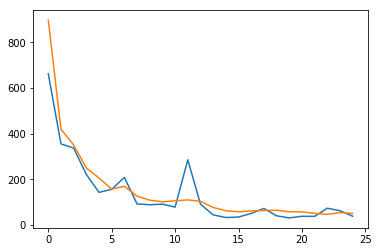

In [38]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])

In [48]:
predictions = model.predict(X).ravel()

In [42]:
tss = np.sum(np.square(y - np.mean(y)))

In [43]:
print('Neural Network Train R squared:', 1 - (history.history['loss'][-1]*X.shape[0]/tss))

Neural Network Train R squared: 0.9736680839780116
